# 基于bert的ner

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
import codecs
import re
import random
import string
from tqdm import tqdm
import pandas as pd
import numpy as np
from zhon.hanzi import punctuation
from sklearn.model_selection import train_test_split
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
from keras_contrib.layers import CRF
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 读取数据

In [2]:
# 数据路径
train_path = "/home/wangwei/tf_workdir/word_detect/data/Train_Data.csv"
test_path = "/home/wangwei/tf_workdir/word_detect/data/Test_Data.csv"
submit_path = "/home/wangwei/tf_workdir/word_detect/data/Submit_Example_Data.csv"

### 缺失值填充和删除

In [137]:
# 开始合并数据
df_train = pd.read_csv(train_path, header=0, encoding='utf-8')
# 对缺失值进行处理
df_train["title"] = df_train["title"].fillna('')
df_train["text"] = df_train["text"].fillna('')
df_train = df_train[df_train["unknownEntities"].notnull()]  # 剔除没有新词的行(剔除了300个，数量有点大)

df_test = pd.read_csv(test_path, header=0, encoding='utf-8')
df_test["title"] = df_test["title"].fillna('')
df_test["text"] = df_test["text"].fillna('')

## 数据预处理

### 定义正则表达式的pattern

In [4]:
## 数据预处理
pattern1 = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') # 剔除链接
pattern2 = re.compile("\{IMG.*?\}") # 剔除{IMG:1}{IMG:2}等等
# pattern3 = re.compile("（.*?\）") # 剔除括号等等
pattern4 = re.compile("《.*?\》") # 剔除括号等等
pattern5 = re.compile("【.*?】") # 删除括号内容
pattern6 = re.compile("\?+")    # 删除多个问号
pattern7 = re.compile("[\w!#$%&'*+/=?^_`{|}~-]+(?:\.[\w!#$%&'*+/=?^_`{|}~-]+)*@(?:[\w](?:[\w-]*[\w])?\.)+[\w](?:[\w-]*[\w])?")    # 邮箱
pattern8 = re.compile("0\d{2}-\d{8}|0\d{3}-\d{7}|\d{5}-\d{5}")  # 剔除电话
pattern9 = re.compile("(20\d{2}([\.\-/|年月\s]{1,3}\d{1,2}){2}日?(\s?\d{2}:\d{2}(:\d{2})?)?)|(\d{1,2}\s?(分钟|小时|天)前)") # 日期
pattern10 = re.compile("<.*?>")
pattern = [pattern1, pattern2, pattern4, pattern5, pattern6, pattern7, pattern8, pattern9, pattern10]

### 定义各种数据处理函数

In [5]:
def clean_zh(text):
    '''清洗文本，保证语句通顺(关于小数点的问题无法处理)'''
    text = text.replace("（", "(").replace("）", ")")
    punct = string.punctuation + punctuation
    punct = "".join([c for c in punct if c not in [".", "、", "%", "“", "”", "(", ")", "！", "。", "？"]])
    text = re.sub(r"[%s]+" % punct, " ", text)
    # 将引号替换
    text = re.sub(r"[%s]+" % "“”()", "", text)
    text = re.sub(r"[%s]+" % "：", " ", text)
    # 多个空格替换成一个
    text = re.sub(' +', ' ', text)
    return text

def clean_data(text):
    """清理各种脏数据"""
    for p in pattern:
        text = re.sub(p, "", text)
    text = clean_zh(text)
    return text

def clean_label(label):
    """对标签进行清洗"""
    label_list = []
    label = re.sub(pattern6, "", label)
    # 替换
    label = label.replace("（", "(").replace("）", ")")
    label = re.sub(r"[%s]+" % "()", "", label)
    return label

def is_contain(col, words):
    words_list = words.split(";")  # 多个实体
    length = len(words_list)
    flag = []
    for word in words_list:
        if word in col:
            flag.append(1)
    if len(flag) == length:
        return 1
    else:
        return 0
    
def title_contain(col, words):
    words_list = words.split(";")  # 多个实体
    flag = 0 
    for word in words_list:
        if word in col:
            flag = 1
    return flag

# 由于每个句子较长，这里只去包含新词实体的句子
def get_sentence(text, words):
    """缩小数据规模"""
    new_str = []
    # 按照多个分隔符进行分割
    sentences = re.split("。|！|？", text.strip())
    words_list = words.split(";")   # 多个实体
    for sent in sentences:
        for word in words_list:
            if word in sent and sent not in new_str:
                new_str.append(sent)
    return "。".join(new_str)

### 开始数据处理

In [6]:
df_train["title"] = df_train["title"].map(lambda x: clean_data(x))
df_train["text"] = df_train["text"].map(lambda x: clean_data(x))
df_train["unknownEntities"] = df_train["unknownEntities"].map(lambda x: clean_label(x))

In [7]:
df_train['text_flag'] = df_train[['text','unknownEntities']].apply(lambda x: is_contain(*x), axis=1)
df_train['title_flag'] = df_train[['title','unknownEntities']].apply(lambda x: title_contain(*x), axis=1)

In [8]:
# 这里剔除样本数据
df_train = df_train[(df_train['text_flag'] == 1 ) | (df_train['title_flag'] == 1)]

### 定义词汇和标注函数

In [9]:
# 定义tag词汇
tags = ["O", "B", "I"]
tag2idx = {tag: i+1 for i, tag in enumerate(tags)}
tag2idx["-PAD-"] = 0
n_tags = len(tag2idx)

In [10]:
# 按照句长进行实体标注
def remark_tag(text, words):
    """多个实体进行标注"""
    tag_list = ["O"] * len(text)
    words_list = words.split(";")  # 多个实体
    for word in words_list:
        # 获取字符串在文本出现的所有下标
        start_index = [w.start() for w in re.finditer(word, text)]
        for index in start_index:
            tag_list[index] = "B"
            tag_list[(index + 1): (index + len(word))] = ["I"] * (len(word) - 1)
    assert len(text) == len(tag_list)
    return tag_list

## bert部分

### bert的存储路径

In [11]:
config_path = "/home/wangwei/pretrain_data/bert/chinese_L-12_H-768_A-12/bert_config.json"
checkpoint_path = "/home/wangwei/pretrain_data/bert/chinese_L-12_H-768_A-12/bert_model.ckpt"
dict_path = "/home/wangwei/pretrain_data/bert/chinese_L-12_H-768_A-12/vocab.txt"

### 自定义tokenizer

In [12]:
# 词汇表
token_dict = {}
with codecs.open(dict_path, "r", encoding="utf-8") as f:
    for line in f:
        token = line.strip()
        token_dict[token] = len(token_dict)

class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # space类用未经训练的[unused1]表示
            else:
                R.append('[UNK]')  # 剩余的字符是[UNK]
        return R

### 加载bert权重和网络结构

In [13]:
tokenizer = OurTokenizer(token_dict)
bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)

In [14]:
bert_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm/add_1:0' shape=(?, ?, 768) dtype=float32>]

### 生成训练集和验证集，以及测试集

In [15]:
# 获取数据
def get_train_data():
    train_data = []
    n2id = []
    for id, t, c, e, text_flag, title_flag in zip(df_train["id"], df_train["title"], df_train["text"], df_train["unknownEntities"], df_train['text_flag'], df_train['title_flag']):
        if text_flag == 1:
            c = get_sentence(c, e)
        else:
            c = get_sentence(t, e)
        # 实体标注
        try:
            n = remark_tag(c, e)
            n2id = [list(map(lambda x: tag2idx[x], sample)) for sample in n]
        except Exception as e:
            print(c)
            print(e)
            print("*"*50)
        train_data.append((id, c, n2id))
    return train_data

In [16]:
train_data = get_train_data()

In [17]:
len(train_data), df_train.shape

(4433, (4433, 6))

In [18]:
print(train_data[0])

('83dcefb7', '揭秘趣步骗局 趣步是什么 趣步是怎么赚钱的。趣步公司可靠吗。趣步合法吗。相信是众多小伙伴最关心的话题 今天小编就来给大家揭开趣步这面丑恶且神秘的面纱 让小伙伴们看清事情的真相。接下来 我用简单的文字 给大家详细剖析一下趣步公司及趣步app的逻辑到底是什么样的', [[1], [1], [2], [3], [1], [1], [1], [2], [3], [1], [1], [1], [1], [2], [3], [1], [1], [1], [1], [1], [1], [1], [2], [3], [1], [1], [1], [1], [1], [1], [2], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [1], [1], [1], [2], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]])


In [19]:
len(train_data[0][1]),len(train_data[0][2])

(129, 129)

In [20]:
id_, text_id, X1, X2, Y = [], [], [], [], []
maxlen = 512
for i in range(len(train_data)):
    d = train_data[i]
    text = d[1][:maxlen]
    y = d[2][:maxlen]
    x1, x2 = tokenizer.encode(first=text)
    X1.append(x1)
    X2.append(x2)
    Y.append(y)
    id_.append([i])
    text_id.append([d[0]])
X1 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=X1, padding="post", value=0)
X2 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=X2, padding="post", value=0)
Y = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=Y, padding="post", value=0)
Y = [keras.preprocessing.utils.to_categorical(i, num_classes=n_tags) for i in Y]

In [21]:
len(id_), len(text_id), X1.shape, X2.shape, len(Y), Y[0].shape

(4433, 4433, (4433, 512), (4433, 512), 4433, (512, 4))

In [22]:
id_train, id_test, text_id_train, text_id_test, X1_train,  X1_test, X2_train,  X2_test, Y_train, Y_test = train_test_split(id_, text_id, X1, X2, Y, test_size=0.1)

In [23]:
len(id_train), len(id_test), len(text_id_train), len(text_id_test), X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, len(Y_train), len(Y_test)

(3989,
 444,
 3989,
 444,
 (3989, 512),
 (444, 512),
 (3989, 512),
 (444, 512),
 3989,
 444)

In [24]:
s_id = random.sample(range(len(id_train)), 1)[0]
s_id

948

In [25]:
id_train[s_id]

[1716]

In [26]:
text_id_train[s_id]

['7ed5aa77']

In [27]:
print(train_data[1716])

('7ed5aa77', '悦花越有在灾害发生后第一时间向九寨沟县地震灾区捐款100万元资助灾区人民重建家园。 之后 悦花越有以最快的速度在平台发起了捐积分 援四川的大转盘抽奖献爱心活动 号召平台用户为灾区献出自己的爱心。 悦花越有平台用户响应积极 纷纷伸出援助之手 为灾区人民奉献了自己爱心。参与悦花越有本次大转盘献爱心活动的人数超过7100人 最终平台用户冯媛女士从众多用户中有幸被抽中。身为悦花越有平台的忠诚用户 她将会以悦天使的身份 代表悦花越有为灾区传递爱心。 灾难发生后 悦花越有心系灾区人民 积极发挥社会责任感与企业影响力 不仅通过捐款帮助灾区 更是以企业平台和号召力呼吁企业员工及用户为灾区人民献爱心 提供帮助。 未来 悦花越有还会持续关注九寨沟灾区的动态 悦花越有为灾区人民祈福 愿灾区人民早日度过难关 重建家园', [[2], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [

In [28]:
len(train_data[1716][1]), len(train_data[1716][2])

(351, 351)

##  自定义ner模型

### 定义模型

In [29]:
x1_in = keras.layers.Input(shape=(None,)) # 待识别句子输入
x2_in = keras.layers.Input(shape=(None,)) # 待识别句子输入
bert_output = bert_model([x1_in, x2_in])
lstm = keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True))(bert_output)
drop = keras.layers.Dropout(0.4)(lstm)
dense = keras.layers.TimeDistributed(keras.layers.Dense(128, activation="relu"))(drop)
crf = CRF(n_tags)
out = crf(dense)
model = keras.models.Model(inputs=[x1_in, x2_in], outputs=out)
model.compile(loss=crf.loss_function, optimizer='adam', metrics=[crf.accuracy])
# model.compile(loss=keras.losses.crf_loss, optimizer='adam', metrics=[keras.metrics.crf_accuracy])
model.summary()

/home/wangwei/miniconda3/envs/tf3/lib/python3.5/site-packages/keras_contrib-2.0.8-py3.5.egg/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/home/wangwei/miniconda3/envs/tf3/lib/python3.5/site-packages/keras_contrib-2.0.8-py3.5.egg/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, None, 768)    101677056   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 256)    918528      model_2[1][0]                    
__________

In [30]:
save_path = "/home/wangwei/tf_workdir/word_detect/model"
filepath="model_{epoch:02d}-{val_crf_viterbi_accuracy:.4f}.hdf5"

In [31]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    keras.callbacks.ModelCheckpoint(os.path.join(save_path, filepath), monitor='val_loss', save_best_only=True, verbose=0),
]

### 训练过程

In [32]:
history = model.fit([X1_train, X2_train], np.array(Y_train), batch_size=64, epochs=20,
                    validation_data=([X1_test, X2_test], np.array(Y_test)), verbose=1, callbacks=callbacks)

Train on 3989 samples, validate on 444 samples
Epoch 1/20
3989/3989 [==============================] - 238s 60ms/step - loss: 7.9539 - crf_viterbi_accuracy: 0.8932 - val_loss: 7.4705 - val_crf_viterbi_accuracy: 0.9329
Epoch 2/20
3989/3989 [==============================] - 230s 58ms/step - loss: 7.7739 - crf_viterbi_accuracy: 0.9318 - val_loss: 7.4365 - val_crf_viterbi_accuracy: 0.9378
Epoch 3/20
3989/3989 [==============================] - 231s 58ms/step - loss: 7.7371 - crf_viterbi_accuracy: 0.9429 - val_loss: 7.4174 - val_crf_viterbi_accuracy: 0.9470
Epoch 4/20
3989/3989 [==============================] - 231s 58ms/step - loss: 7.7145 - crf_viterbi_accuracy: 0.9530 - val_loss: 7.4022 - val_crf_viterbi_accuracy: 0.9547
Epoch 5/20
3989/3989 [==============================] - 232s 58ms/step - loss: 7.6976 - crf_viterbi_accuracy: 0.9627 - val_loss: 7.3880 - val_crf_viterbi_accuracy: 0.9723
Epoch 6/20
3989/3989 [==============================] - 231s 58ms/step - loss: 7.6834 - crf_viterb

###  绘制训练图形

In [33]:
hist = pd.DataFrame(history.history)
hist.head()

,crf_viterbi_accuracy,loss,val_crf_viterbi_accuracy,val_loss
0,0.893216,7.953896,0.932912,7.470517
1,0.931815,7.773933,0.937818,7.436458
2,0.942886,7.737079,0.947018,7.417439
3,0.952999,7.714459,0.954731,7.402221
4,0.962738,7.697616,0.972331,7.388022


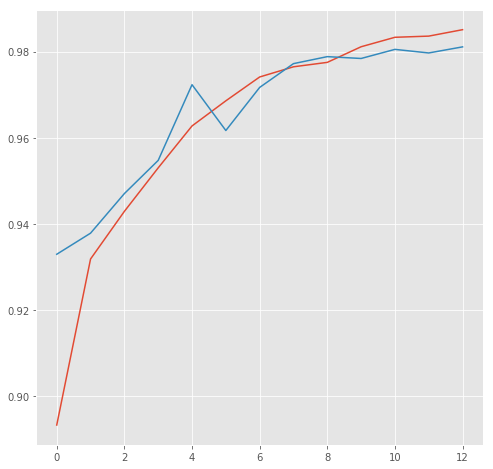

In [34]:
plt.style.use("ggplot")
plt.figure(figsize=(8,8))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [35]:
### 对验证集进行各种度量指标计算

In [36]:
X1_test.shape

(444, 512)

In [37]:
test_pred = model.predict([X1_test, X2_test], verbose=1)

444/444 [==============================] - 21s 48ms/step


In [38]:
idx2tag = {i: w for w, i in tag2idx.items()}
print("tag2idx:", tag2idx)
print("idx2tag:", idx2tag)

tag2idx: {'B': 2, 'O': 1, 'I': 3, '-PAD-': 0}
idx2tag: {0: '-PAD-', 1: 'O', 2: 'B', 3: 'I'}


In [39]:
test_pred.shape

(444, 512, 4)

In [40]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("-PAD-", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(Y_test)

In [41]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 84.1%


In [42]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

        B       0.87      0.90      0.89      2093
        I       0.77      0.82      0.79      2089

micro avg       0.82      0.86      0.84      4182
macro avg       0.82      0.86      0.84      4182



### 验证个例

In [43]:
# 随机抽样
sample_id = random.sample(range(len(id_test)), 1)[0]
sample_X1 = X1_test[sample_id]
sample_X2 = X2_test[sample_id]
tid = id_test[sample_id][0]
sample_text_id = text_id_test[sample_id]
print(sample_text_id)
sample_data = train_data[tid]
print(sample_data)
sample_Y = Y_test[sample_id]
print(sample_Y)

['3c27e9bb']
('3c27e9bb', 'ICA亚投链矿机投资配股拆分理财开发找13郑286婷015微737电。ICA亚投链网上投资理财app开发、ICA亚投链虚拟币投资分红模式开发、ICA亚投链理财平台网页版定制开发、ICA亚投链区块链分红系统程序开发区块链技术的定义是什么。ICA亚投链模式制度介绍 注册免费送12万台矿机 数量有限 送完为止。ICA亚投链全球恒量发行1 5亿枚 永不增发 开盘价0 2美元 预计开盘交易黑市价不低于2美元 市场更是一币难求 采取有效的控盘机制。ICA亚投链全球恒量发行1 5亿枚 永不增发。ICA亚投链资质背书 双加密网址 独立开源代码 采用POW智能合约 POS算力 对接商城 话费 水电费充值 中石油、中石化充值 ICA亚投链推广奖励 矿工公会ICA亚投链奖励 一代 拿直推收益总产量的5%低于直推算力 收益减半二代 3%三代 1%一星会长 直推10人 团队100人 工会算力 总算力达到20GH S 送小型矿机一台', [[2], [3], [3], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [3], [3], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [

In [44]:
sample_X1.shape

(512,)

In [45]:
predict = model.predict([sample_X1.reshape([1, -1]), sample_X2.reshape([1, -1])])
print(predict.shape)

(1, 512, 4)


In [46]:
pred = np.argmax(predict, axis=-1).reshape([-1])
true = np.argmax(sample_Y, axis=-1)

In [47]:
pred_label = [idx2tag[i] for i in pred]
true_label = [idx2tag[i] for i in true]

In [48]:
for c, t, p in zip(sample_data[1], pred_label, true_label):
    if t != "-PAD-":
        print("{:15}: {:5} {}".format(c, t, p))

I              : B     B
C              : I     I
A              : I     I
亚              : I     I
投              : I     I
链              : I     I
矿              : O     O
机              : O     O
投              : O     O
资              : O     O
配              : O     O
股              : O     O
拆              : O     O
分              : O     O
理              : O     O
财              : O     O
开              : O     O
发              : O     O
找              : O     O
1              : O     O
3              : O     O
郑              : O     O
2              : O     O
8              : O     O
6              : O     O
婷              : O     O
0              : O     O
1              : O     O
5              : O     O
微              : O     O
7              : O     O
3              : O     O
7              : O     O
电              : O     O
。              : O     O
I              : B     B
C              : I     I
A              : I     I
亚              : I     I
投              : I     I


In [49]:
def get_entity(X_data, y_data):
    """
    """
    entity_list = []
    entity_name = ''
    for i, (c, l) in enumerate(zip(X_data, y_data)):
        if l == "B":
            entity_name += c
        elif (l == "I") and (len(entity_name)) > 0:
            entity_name += c
            if i == len(y_data) - 1:
                entity_list.append(entity_name)
        elif l == "O":
            if len(entity_name) > 0:
                entity_list.append(entity_name)
            entity_name = ''
            
    return " ".join(list(set(entity_list)))

In [50]:
X_data = [c for c in sample_data[1]]
print(X_data)

['I', 'C', 'A', '亚', '投', '链', '矿', '机', '投', '资', '配', '股', '拆', '分', '理', '财', '开', '发', '找', '1', '3', '郑', '2', '8', '6', '婷', '0', '1', '5', '微', '7', '3', '7', '电', '。', 'I', 'C', 'A', '亚', '投', '链', '网', '上', '投', '资', '理', '财', 'a', 'p', 'p', '开', '发', '、', 'I', 'C', 'A', '亚', '投', '链', '虚', '拟', '币', '投', '资', '分', '红', '模', '式', '开', '发', '、', 'I', 'C', 'A', '亚', '投', '链', '理', '财', '平', '台', '网', '页', '版', '定', '制', '开', '发', '、', 'I', 'C', 'A', '亚', '投', '链', '区', '块', '链', '分', '红', '系', '统', '程', '序', '开', '发', '区', '块', '链', '技', '术', '的', '定', '义', '是', '什', '么', '。', 'I', 'C', 'A', '亚', '投', '链', '模', '式', '制', '度', '介', '绍', ' ', '注', '册', '免', '费', '送', '1', '2', '万', '台', '矿', '机', ' ', '数', '量', '有', '限', ' ', '送', '完', '为', '止', '。', 'I', 'C', 'A', '亚', '投', '链', '全', '球', '恒', '量', '发', '行', '1', ' ', '5', '亿', '枚', ' ', '永', '不', '增', '发', ' ', '开', '盘', '价', '0', ' ', '2', '美', '元', ' ', '预', '计', '开', '盘', '交', '易', '黑', '市', '价', '不', '低', '于', '2', '美', '元',

In [51]:
get_entity(X_data, pred_label)

'ICA亚投链'

## 预测测试集

### 处理测试集

In [ ]:
def clean_zh(text):
    '''清洗文本，保证语句通顺(关于小数点的问题无法处理)'''
    text = text.replace("（", "(").replace("）", ")")
    punct = string.punctuation + punctuation
    punct = "".join([c for c in punct if c not in [".", "、", "%", "“", "”", "(", ")", "！", "。", "？"]])
    text = re.sub(r"[%s]+" % punct, " ", text)
    # 将引号替换
    text = re.sub(r"[%s]+" % "“”()", "", text)
    text = re.sub(r"[%s]+" % "：", " ", text)
    # 多个空格替换成一个
    text = re.sub(' +', ' ', text)
    return text

def clean_data(text):
    """清理各种脏数据"""
    for p in pattern:
        text = re.sub(p, "", text)
    text = clean_zh(text)
    return text

In [56]:
df_test["title"] = df_test["title"].map(lambda x: clean_data(x))
df_test["text"] = df_test["text"].map(lambda x: clean_data(x))

In [62]:
df_test["new_text"] = df_test["title"]  + " " + df_test["text"]

In [63]:
df_test.head()

,id,title,text,new_text
0,83dcefb7,时空周转公众注册 当天秒下,时空周转是一款非常靠谱的小额现金快捷贷款平台。时空周转贷款申请到下款全过程都是在手机上完成的...,时空周转公众注册 当天秒下 时空周转是一款非常靠谱的小额现金快捷贷款平台。时空周转贷款申请到...
1,1ad5be0d,抢红包、做任务、缺销路、缺人脉、推广产品 来这就对了 兼职赚钱 聚集人脉,本篇文章将对两种人群进行分析 一种是不做任何项目 只撸些APP拉新 做做任务赚钱的纯羊毛党 ...,抢红包、做任务、缺销路、缺人脉、推广产品 来这就对了 兼职赚钱 聚集人脉 本篇文章将对两种...
2,6dd28e9b,,2019健康行业趋势 住家创业 稳赚不亏,2019健康行业趋势 住家创业 稳赚不亏
3,f3b61b38,CCM区块链商城PPT介绍,CCM区块链商介绍CCM3 0我们会开启CCM矿石的互转流通 和支持商家入驻 到时候大家有自...,CCM区块链商城PPT介绍 CCM区块链商介绍CCM3 0我们会开启CCM矿石的互转流通 和...
4,84b12bae,加密数字货币里大家都赚钱 钱是从哪里来的？,我最近去分享艾尔链LAC加密数字货币时 有很多朋友都对我轻蔑一笑 或者抱着怀疑的态度 经常拿...,加密数字货币里大家都赚钱 钱是从哪里来的？ 我最近去分享艾尔链LAC加密数字货币时 有很多朋...


In [64]:
df_test.shape

(4998, 4)

In [65]:
# 对测试集的文本进行分割，担心正文内容太长
def split_text(seq_list, maxlen):
    res = []
    for tuple_ in seq_list:
        id = tuple_[0]
        if len(tuple_[1]) > maxlen:
            num_sent = len(tuple_[1]) // maxlen
            if len(tuple_[1]) % maxlen != 0:
                num_sent += 1
            for i in range(num_sent):
                res.append((id, tuple_[1][i*maxlen: (i+1)*maxlen]))
        else:
            res.append((id, tuple_[1]))
    return res

In [68]:
def get_test_data():
    test_data = []
    for id, c in zip(df_test["id"], df_test["new_text"]):
        test_data.append((id, c))
    return test_data

In [69]:
test_d = get_test_data()

In [70]:
len(test_d)

4998

In [71]:
maxlen

512

In [72]:
test_res = split_text(test_d, maxlen)

In [75]:
test_res[0]

('83dcefb7',
 '时空周转公众注册 当天秒下 时空周转是一款非常靠谱的小额现金快捷贷款平台。时空周转贷款申请到下款全过程都是在手机上完成的。扫一扫 立即申请时空周转app功能1、极速放款 自动审核、极速放款、实时到账 2、流程简单 在线填写资料 芝麻信用授权即可贷款 3、信息安全 数据库加密技术、保护借款人隐私 4、随借随还 无论何时何地、借款轻松 还款便捷。时空周转app亮点1、闪电借款 纯线上自动化审核 快至30分钟到账 2、额度灵活 单期借款、现金分期 万元额度任你选。3、门槛超低 无门槛、无担保 有身份证即可借款。关注我们 更多口子信息问 有人在时空周转借款过吗答 时空周转正常情况下2 3小时以内 也有特殊情况。问 时空周转贷款审核需要多少时间 时空周转贷款审核时间多长答 提前还款后 也还是能继续在时空周转借款的。问 时空周转没有还清还可以申请吗？答 时空周转！不需要太多的条件 借款也很快！问 时空周转真的像广告里面说的没有信用卡也能贷款吗答 用过 不是的 时空周转最大的好处就是可以节省分期的手续费问 时空周转好用吗时空周转 使用的人多不多啊答 时空周转它的手续费是比较低的 而且还款压力也比较小的。低于银行七哩八。5万')

In [74]:
len(test_res)

12235

In [73]:
sub_id = []
sub_text = []
sub_X1 = []
sub_X2 = []
for tuple_ in test_res:
    sub_id.append(tuple_[0])
    x1, x2 = tokenizer.encode(first=tuple_[1])
    sub_X1.append(x1)
    sub_X2.append(x2)
    sub_text.append(tuple_[1])
sub_X1 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X1, padding="post", value=0)
sub_X2 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X2, padding="post", value=0)

In [76]:
bs = 64
steps = len(sub_id) // bs
if len(sub_id) % bs != 0:
    steps += 1

In [77]:
result_all = []
for i in tqdm(range(steps)):
    batch_id = sub_id[i*bs:(i+1)*bs]
    batch_text = sub_text[i*bs:(i+1)*bs]
    batch_X1 = sub_X1[i*bs:(i+1)*bs]
    batch_X2 = sub_X2[i*bs:(i+1)*bs]
    batch_pred = model.predict([batch_X1, batch_X2])
    batch_pred = np.argmax(batch_pred, axis=-1).tolist()
    for id, text, pred in zip(batch_id, batch_text, batch_pred):
        pred_label = [idx2tag[i] for i in pred]
        x_data = [c for c in text]
        entity = get_entity(x_data, pred_label)
        result_all.append((id, entity))

100%|██████████| 192/192 [08:38<00:00,  2.15s/it]


In [87]:
last_result = []
for tuple_ in result_all:
    ner = []
    for word in tuple_[1].split(" "):
        if len(word) > 2:
            ner.append(word)
    last_result.append((tuple_[0], " ".join(ner)))

In [88]:
last_result[0]

('83dcefb7', '时空周转 时空周转')

In [89]:
res_dict = dict()
for tuple_ in last_result:
    if tuple_[0] not in res_dict:
        res_dict[tuple_[0]] = tuple_[1].split(" ")
    else:
        res_dict[tuple_[0]] = res_dict[tuple_[0]] + tuple_[1].split(" ")

In [84]:
len(test_d)

4998

'w'

In [90]:
last_res = []
with open("/home/wangwei/tf_workdir/word_detect/submit_test.csv", "w", encoding='utf-8') as f:
    for i in test_d:
        key = i[0]
        value = res_dict[key]
        value = ";".join(list(set(value)))
        f.write(key+','+value+"\n")

In [91]:
with codecs.open("/home/wangwei/tf_workdir/word_detect/submit_test1.csv", "w", encoding="utf-8") as f:
    for i in test_d:
        key = i[0]
        value = res_dict[key]
        value = ";".join(list(set(value)))
        f.write(key+','+value+"\n")

### 处理测试集2

In [93]:
df_test["title"] = df_test["title"].map(lambda x: clean_data(x))
df_test["text"] = df_test["text"].map(lambda x: clean_data(x))

In [114]:
df_test[df_test["id"] == "1414e381"]["text"].values

array(['SMRT 智慧地球2010年由全美零售业联盟会、新兴市场基金会简称EMF发起研发 基金会团队分布在美国硅谷、巴黎、韩国、印度 四大研发中心号上线 智慧地球🌍首先呢？它不是一个单线平台、是基于多个模块、分不同阶段不同地区和国家进行、相互独立又相互依存、所以说呢地球🌍不是一个简单的拆分、拆分只不过是前期的一部个启动器而已、分区块连🌍社交软件APP浏览器等、商业板块 学习模块、游戏道具交易买卖板块、数字货币交易网站的打造、像火币网一样的数字货币三大交易平台打造、新加坡 迪拜、马耳它、亚洲国家一个中东国家一个欧洲国家一个、自然界 区块链数字货币的打造！作为地球🌍多国渡全生态 交易的价值媒介 实现全球点对点交易无障碍通道 不同模块在不同阶段适时推出为地球🌍每个阶段更好的发展、地球🌍平台志向高远、目前许多玩家仅仅停留在或了解到的只是地球的初级阶段的一小部分东西 地球志向高远 早已经走在了时代的前沿 表面上是一种新的数据结构与计算方式 但其核心价值在于重塑人类交易方式和共识机制 智慧地球🌍每个板块都是一环扣一环环环相扣 未来5个发展阶段和布局结构全部提前规划出行路线和技术的储备 适时推出即可 跟着路线走就行 1️⃣第一阶段SmartGlobe的研发设计 初始建设者招募与教育 也就是玩家的培育 打好根基的意思2️⃣SmartGlobe正式面世 努力打造Z频道链接Amazon 将趣味购物 利润均享的先进理念带入新兴市场区块链APP社交软件和浏览器等3️⃣阶段当建设者 消费者总量达到5万人 SmartGoble智慧地球建设初具规模 开放20万EP的商业单元 审核通过的建设者自有品牌商家便可自主开设一个面向5万人存量消费者的特色商铺。同时 战略合作专用的即时通讯工具上线 方便交易方线上沟通 方便各支SmartGoble建设分队学习交流、包括三国区块链数字交易平台上线运营、自然界 数字货币全球点对点交易支付媒介及数字资产、商品全球买全球卖全球支付体系的建设。4️⃣当建设者 消费者总量达到50万人 开放50万EP的通讯单元 Z频道独立剥离 引入风投或采用众筹模式 推向资本市场5️⃣管委会可控基金达到一定规模 借由专业投资团队 介入优势产业、物色包装有潜力的优质企业。让SmartGlobe以资本的力量 引发共存共赢的理念在全球传播！SmartGlobe优秀的建设者将有优先权 畅

In [136]:
df_test[df_test["id"] == "5a8717fa"]["text"].values

array([' 公告 上银基金管理有限公司 上银中债1 3年农发行债券指数 关于上银中债1 3年农发行债券指数证券投资基金提前结束募集的公告时间 中财网上银基金管理有限公司关于上银中债1 3年农发行债券指数证券投资基金提前结束募集的公告上银中债1 3年农发行债券指数证券投资基金基金简称 上银中债13年农发行债券指数 基金代码 007390 以下简称本基金于经中国证监会证监许可 2019 548号文准予注册募集。本基金已于起开始募集 原定募集截止日为。为充分保护基金份额持有人利益 根据目前本基金销售情况及、、的有关规定 经与本基金托管人股份有限公司协商一致 上银基金管理有限公司决定提前结束本基金的募集 募集截止日提前至 自含当日起不再接受认购申请。敬请投资者留意。投资者可以通过以下途径咨询本基金其他有关信息 1、上银基金管理有限公司客户服务电话 021602319992、上银基金管理有限公司网站 www boscam com cn风险提示 基金管理人承诺以诚实信用、勤勉尽责的原则管理和运用基金资产 但不保证基金一定盈利 也不保证最低收益。投资者投资于本基金前应认真阅读本基金的基金合同和招募说明书。敬请投资者注意投资风险。特此公告上银基金管理有限公司二〇一九年六月十八日 中财网'],
      dtype=object)

In [119]:
test_data = []
for id, title, text in zip(df_test["id"], df_test["title"], df_test["text"]):
    p = re.compile(u"[^a-zA-Z0-9\u4e00-\u9fa5]")
    line = p.sub(' ',line)
    line = re.sub(' +', ' ', line)
    test_data.append((id, text))

In [120]:
len(test_data)

9226

In [126]:
test_data[3]

('1ad5be0d',
 '本篇文章将对两种人群进行分析 一种是不做任何项目 只撸些APP拉新 做做任务赚钱的纯羊毛党 另一种是做项目 带团队的专职网赚者 通过本篇文章 你们会知道这才是你想要的东西 首先讲纯羊毛党 打开此款APP 我发现 这里真是纯羊毛党的天堂 对于羊毛党 我只介绍这两个功能 1 红包大厅 有做项目的为了推广项目 会发些图方广告 以红包的形式 你只要观看10秒 就能抢到红包 对于羊毛党来说 向来是以量取胜的 而且你若有心 你会发现不少的优质项目 一手资源如图 2 任务大厅 就跟其它比如蚂蚁 牛帮 众人帮等任务平台一样 这里可以发任务 接任务 价格也不错 最有突出的一个就是有朋友圈任务 简单转发到朋友圈 最低是1元 条 两三块 条的也有 每天光接这些任务 都够你一天几十的了 如图 3 这里要顺便说下我的微信群 大家都知道 每个任务平台收徒弟 徒弟完成任务 师傅是有奖励的 之前我建立了众人帮 牛帮 余赚网 闲趣赚这几个平台的徒弟群 每天返70%的奖励给大家 得到了很好的效果 大家做任务都很积极 也得到了更多的奖励 现在我又单独建立了全民推的群 因为我发现全民推 在我开通了金牌站长 VIP会员后 我能得到徒弟30%的奖励 所以 这个数字是非常可观的 为此 请做任务的兄弟们 一定要走我链接 加我微信 进群享高额分红 每天红包雨让你爽翻天 往下拉 加我微信进群 第二种人群 专职网赚带队干项目的为什么一定要来这里呢请先听下我的故事 最近我手上有不少的好项目 却一直建立不起来一个更大的团队 思前思后 主要是没有找到可以引流的池子 一直到我有天看朋友圈发现有人在推广这个APP 下载之后才发现这里是真正的流量池 好了 我只说到这 干项目的都不是傻子 我只发点图给你们看 其它自己揣摩 第一张 请注意 数字 1 79亿 再看中间广告页的点击率 这上面是不断刷新的这一张 是加粉中心页面 可以把自己微信 群 小程序 公众号 甚至货源发上去综上所述 我觉得全民推这款APP是值得大家下载安装的 点击左下角阅读原文做任务的伙伴们记得加我微信进群享每日70%分红 有钱大家一起赚才是正确的操作方式 跟我干有钱赚点击 阅读原文 注册▼往期精彩回顾▼淘宝评价自动变现小而美的项目全国招收云闪付推广员 18元 单 一单一结手机端POS机 店小友 手机就是POS机 央行支付牌照 用友集团旗下

In [127]:
sub_id = []
sub_text = []
sub_X1 = []
sub_X2 = []
for tuple_ in test_data:
    sub_id.append(tuple_[0])
    x1, x2 = tokenizer.encode(first=tuple_[1][:maxlen])
    sub_X1.append(x1)
    sub_X2.append(x2)
    sub_text.append(tuple_[1])
sub_X1 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X1, padding="post", value=0)
sub_X2 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X2, padding="post", value=0)

In [128]:
bs = 64
steps = len(sub_id) // bs
if len(sub_id) % bs != 0:
    steps += 1

In [129]:
result_all = []
for i in tqdm(range(steps)):
    batch_id = sub_id[i*bs:(i+1)*bs]
    batch_text = sub_text[i*bs:(i+1)*bs]
    batch_X1 = sub_X1[i*bs:(i+1)*bs]
    batch_X2 = sub_X2[i*bs:(i+1)*bs]
    batch_pred = model.predict([batch_X1, batch_X2])
    batch_pred = np.argmax(batch_pred, axis=-1).tolist()
    for id, text, pred in zip(batch_id, batch_text, batch_pred):
        pred_label = [idx2tag[i] for i in pred]
        x_data = [c for c in text]
        entity = get_entity(x_data, pred_label)
        result_all.append((id, entity))

100%|██████████| 145/145 [06:33<00:00,  2.17s/it]


In [135]:
result_all[-100:]

[('982e5921', ''),
 ('982e5921', ''),
 ('0127089b', '凤推'),
 ('0127089b', '凤推'),
 ('7620380d', '比特挖矿 比特挖'),
 ('7620380d', ' 矿机 比特挖矿'),
 ('e69f259c', '简啦啦'),
 ('e69f259c', '简啦啦'),
 ('9198150a', 'fxcm'),
 ('f15f9cef', '创富国际有限公司 国付宝信息 国付宝 国付宝信息科技有限公司 创富国际'),
 ('8658ac79', '行聊 ctb'),
 ('1f51fdc3', '腾邦现货'),
 ('1f51fdc3', '腾邦集团 腾邦 腾邦现货'),
 ('6856cd55', ''),
 ('6856cd55', ''),
 ('f63258f6', '三立集团'),
 ('81356860', ''),
 ('81356860', ''),
 ('183c39da', '恐'),
 ('183c39da', ' 鼎泽'),
 ('6f3b094c', '华盛资本'),
 ('6f3b094c', '华盛资本'),
 ('ff8414dd', '金融危'),
 ('ff8414dd', '金融'),
 ('8883244b', '盾安债甩券 合晟资产'),
 ('8883244b', '盾安 败。盾安 持有盾安债 踩雷盾安债 盾安债 前 泓德基金 盾安集'),
 ('da72cf2c', '淘钱宝'),
 ('da72cf2c', '多米 淘钱宝'),
 ('ad75ffba', '爱乐在线'),
 ('ad75ffba', '爱乐在线 张先生'),
 ('347cae00', '商机头条'),
 ('347cae00', '商机头条'),
 ('437b9e96', '素店'),
 ('437b9e96', '素店 靠吗素店 妮素国际'),
 ('dd1f0b35', ''),
 ('dd1f0b35', '华润信托'),
 ('aa183ba3', '比特币 IPFS存储'),
 ('aa183ba3', '比特币'),
 ('33116a19', '宝网贷'),
 ('33116a19', '收获宝'),
 ('44165a8f', '龙腾盛世'),

In [ ]:
last_result = []
for tuple_ in result_all:
    ner = []
    for word in tuple_[1].split(" "):
        if len(word) > 2:
            ner.append(word)
    last_result.append((tuple_[0], " ".join(ner)))

In [ ]:
# 去除所有半角全角符号，只留字母、数字、中文。
def remove_punctuation(line):
    p = re.compile(ur"[^a-zA-Z\u4e00-\u9fa5]")
    line = p.sub('',line)
    line = re.sub(' +', ' ', line)
    return line

### 处理测试集3

In [138]:
df_test["title"] = df_test["title"].map(lambda x: clean_data(x))
df_test["text"] = df_test["text"].map(lambda x: clean_data(x))

In [139]:
df_test.head()

,id,title,text
0,83dcefb7,时空周转公众注册 当天秒下,时空周转是一款非常靠谱的小额现金快捷贷款平台。时空周转贷款申请到下款全过程都是在手机上完成的...
1,1ad5be0d,抢红包、做任务、缺销路、缺人脉、推广产品 来这就对了 兼职赚钱 聚集人脉,本篇文章将对两种人群进行分析 一种是不做任何项目 只撸些APP拉新 做做任务赚钱的纯羊毛党 ...
2,6dd28e9b,,2019健康行业趋势 住家创业 稳赚不亏
3,f3b61b38,CCM区块链商城PPT介绍,CCM区块链商介绍CCM3 0我们会开启CCM矿石的互转流通 和支持商家入驻 到时候大家有自...
4,84b12bae,加密数字货币里大家都赚钱 钱是从哪里来的？,我最近去分享艾尔链LAC加密数字货币时 有很多朋友都对我轻蔑一笑 或者抱着怀疑的态度 经常拿...


In [147]:
test_data = []
for id, title, text in zip(df_test["id"], df_test["title"], df_test["text"]):
    p = re.compile(u"[^a-zA-Z0-9\u4e00-\u9fa5]")
    line = p.sub(' ',line)
    line = re.sub(' +', ' ', line)
    test_data.append((id, text))

In [148]:
sub_id = []
sub_text = []
sub_X1 = []
sub_X2 = []
for tuple_ in test_data:
    sub_id.append(tuple_[0])
    x1, x2 = tokenizer.encode(first=tuple_[1][:maxlen])
    sub_X1.append(x1)
    sub_X2.append(x2)
    sub_text.append(tuple_[1])
sub_X1 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X1, padding="post", value=0)
sub_X2 = keras.preprocessing.sequence.pad_sequences(maxlen=maxlen, sequences=sub_X2, padding="post", value=0)

In [149]:
bs = 64
steps = len(sub_id) // bs
if len(sub_id) % bs != 0:
    steps += 1

In [150]:
steps

79

In [151]:
result_all = []
for i in tqdm(range(steps)):
    batch_id = sub_id[i*bs:(i+1)*bs]
    batch_text = sub_text[i*bs:(i+1)*bs]
    batch_X1 = sub_X1[i*bs:(i+1)*bs]
    batch_X2 = sub_X2[i*bs:(i+1)*bs]
    batch_pred = model.predict([batch_X1, batch_X2])
    batch_pred = np.argmax(batch_pred, axis=-1).tolist()
    for id, text, pred in zip(batch_id, batch_text, batch_pred):
        pred_label = [idx2tag[i] for i in pred]
        x_data = [c for c in text]
        entity = get_entity(x_data, pred_label)
        result_all.append((id, entity))

100%|██████████| 79/79 [03:32<00:00,  2.13s/it]


In [152]:
len(result_all)

4998

In [153]:
result_all[:10]

[('83dcefb7', '时空周转'),
 ('1ad5be0d', '羊毛党'),
 ('6dd28e9b', '住家创业 201'),
 ('f3b61b38', '➗CCM CCM'),
 ('84b12bae', ''),
 ('1db87a14', '富民宝 定活宝 富民银行'),
 ('6abf4a82', '\u200b\u200b\u200b \u200b\u200b\u200b\u200b'),
 ('fa005713', '微信群 微信 微小宠'),
 ('8d076785', '\u200b\u200b 鼎诚创投'),
 ('a15d25e1', '青团社 ▌A 地平线')]

In [164]:
result_all[-30:]

[('b46ecefb', ''),
 ('2d679f41', 'APP 趣步 亦跑 链信'),
 ('5a60afd7', '明堂金融 景山 明堂期货'),
 ('c4043a74', '英皇金融 英皇金融国际'),
 ('b3030ae2', 'HUSDToken 火币钱包 火币'),
 ('2a0a5b58', '鲨鱼记账 网商万宝 网商'),
 ('5d0d6bce', '无限 华景城 华景无限逍遥卡 华景无限旅游 华景无限 华景无限逍'),
 ('cdb2765f', '臻鼎投资  国金中融 国金中融 臻鼎'),
 ('bab546c9', '顺德农商 中国中投 广东顺高投 欧浦小贷'),
 ('44f1e2a2', '易信easymarkets平台'),
 ('33f6d234', '美美 国美在线 国美控股 美美理财 国美 国美在线金融 美易'),
 ('aaff838e', 'P2 芒果金融'),
 ('ddf8b318', '之道 人人 云联惠 云商'),
 ('439c26bb', '神店 神店小'),
 ('349b162d', '华登 beta'),
 ('ad924797', ''),
 ('da957701', '喜牛  中 远特喜牛'),
 ('4a2a6a90', ''),
 ('3d2d5a06', '购房'),
 ('5dead3e3', ''),
 ('2aede375', '恩圣威NCY'),
 ('b3e4b2cf', '明堂金融 景山 明堂期货'),
 ('c4e38259', '洛阳百事通 百事通'),
 ('5a8717fa', '告 上银基金管 财网上银基金管理有限 2、上银基金管理有 致 上银基金管理有限 关于上银 上银基金管理 司 上银'),
 ('2d80276c', '源中瑞 深圳源中瑞科技'),
 ('b48976d6', '农科农业保险公司、农科融资租赁公司'),
 ('c38e4640', '恩圣威 艾拓思'),
 ('53315bd1', 'Finci芬吉'),
 ('24366b47', '爱汇宝'),
 ('3b453440', '赶街')]

In [166]:
# 开始写规则
def clean_ner(text):
    # 不能匹配数字
    text = re.sub("[0-9]", "", text).strip()
    # 不包含\u200b
    text = re.sub("\\u200b", "", text).strip()
    # 剔除
    ner = []
    for n in text.split(" "):
        if len(n) > 1:
            ner.append(n)
    text = ";".join(ner)
    return text

In [167]:
l_res= []
for i in result_all:
    text = clean_ner(i[1])
    l_res.append((i[0], text))

In [171]:
l_res[:10]

[('83dcefb7', '时空周转'),
 ('1ad5be0d', '羊毛党'),
 ('6dd28e9b', '住家创业'),
 ('f3b61b38', '➗CCM;CCM'),
 ('84b12bae', ''),
 ('1db87a14', '富民宝;定活宝;富民银行'),
 ('6abf4a82', ''),
 ('fa005713', '微信群;微信;微小宠'),
 ('8d076785', '鼎诚创投'),
 ('a15d25e1', '青团社;▌A;地平线')]

In [172]:
with codecs.open("/home/wangwei/tf_workdir/word_detect/ww.csv", "w", encoding="utf-8") as f:
    for i in l_res:
        key = i[0]
        value = i[1]
        f.write(key+','+value+"\n")